In [21]:
import doctest

In [22]:
import collections

import numpy as np

import matplotlib.pyplot as plt

import IPython
import IPython.utils.text
import IPython.display as ipd

import sympy as sp
import spb
import sympy.core.random as spr
import sympy.stats as ss
import sympy.plotting as splt
import sympy.physics.vector as spv



spv.init_vprinting()
%matplotlib inline


In [23]:
def directory(obj):
    return [
        str for str in dir(obj) if callable(getattr(obj, str)) & ~str.startswith("_")
    ]

# IPython.utils.text

The `IPython.utils.text` module in the IPython package provides utility
functions for working with text and formatting output in a terminal
environment. It includes various functions for manipulating and
displaying text, as well as functions for managing text colors and styles.

Here are some key functionalities provided by `IPython.utils.text`:

1. Text Formatting:
   - `indent`: Indents a block of text by a specified number of spaces.
   - `wrap_paragraphs`: Wraps paragraphs of text to a specified line width.
   - `dedent`: Removes common leading whitespace from a block of text.
   - `columnize`: Formats a list of strings into columns for more compact display.
   - `sprint`: Formats a string with variable substitutions using curly braces.

2. Text Colors and Styles:
   - `colorize`: Applies ANSI escape sequences to colorize text.
   - `TermColors`: A class that defines color constants for text highlighting.
   - `style`: Applies ANSI escape sequences to style text (e.g., bold, underline).

3. Text Output:
   - `clear_screen`: Clears the terminal screen.
   - `pager`: Displays text content with paging support.
   - `print_table`: Prints a list of lists as a formatted table.
   - `printfield`: Formats a field with a specified width and alignment.

These functions and utilities provided by `IPython.utils.text` are
helpful for enhancing the visual presentation of text in a terminal
environment. They allow for better formatting, indentation,
colorization, and output management, making it easier to work with
and display text-based information in IPython and Jupyter environments.

In [24]:
print(IPython.utils.text.columnize(directory(ipd)))

Audio          JSON               Video               display_markdown      
Code           Javascript         VimeoVideo          display_pdf           
DisplayHandle  Latex              YouTubeVideo        display_png           
DisplayObject  Markdown           clear_output        display_pretty        
FileLink       Math               display             display_svg           
FileLinks      Pretty             display_html        publish_display_data  
GeoJSON        ProgressBar        display_javascript  set_matplotlib_close  
HTML           SVG                display_jpeg        set_matplotlib_formats
IFrame         ScribdDocument     display_json        update_display        
Image          TextDisplayObject  display_latex     



In [25]:
print(IPython.utils.text.columnize(dir(sp.S)))

Catalan           Naturals            __dir__            __ne__             
ComplexInfinity   Naturals0           __doc__            __new__            
Complexes         NegativeInfinity    __eq__             __reduce__         
EmptySequence     NegativeOne         __format__         __reduce_ex__      
EmptySet          One                 __ge__             __repr__           
EulerGamma        Pi                  __getattr__        __setattr__        
Exp1              Rationals           __getattribute__   __sizeof__         
GoldenRatio       Reals               __gt__             __slots__          
Half              TribonacciConstant  __hash__           __str__            
IdentityFunction  UniversalSet        __init__           __subclasshook__   
ImaginaryUnit     Zero                __init_subclass__  _classes_to_install
Infinity          __call__            __le__             false              
Integers          __class__           __lt__             register           

In [26]:
HALF = sp.S.Half
ONE = sp.S.One
PI = sp.pi
E = sp.exp
POSITIVEINFINITY = sp.S.Infinity
NEGATIVEINFINITY = sp.S.NegativeInfinity

# Support Functions

In [27]:
def reference_frame(
    frame: str, x=r"\imath", y=r"\jmath", z=r"\mathbf k"
) -> spv.ReferenceFrame:
    return spv.ReferenceFrame(
        frame,
        latexs=(
            rf"\; {{}}^\mathcal {frame} \hat {x}",
            rf"\;{{}}^\mathcal {frame} \hat {y}",
            rf"\: {{}}^\mathcal {frame} \hat {{z}}",
        ),
    )


def vector(F: spv.ReferenceFrame, rx, ry, rz=0) -> spv.Vector:
    """
    Create a vector in a specified reference frame.

    Args:
        F (spv.ReferenceFrame): The reference frame in which the vector is defined.
        rx (float): The coefficient of the x-axis vector component.
        ry (float): The coefficient of the y-axis vector component.
        rz (float, optional): The coefficient of the z-axis vector component (default: 0).

    Returns:
        spv.Vector: The vector composed of the specified components in the given reference frame.

    Examples:
        >>> N = spv.ReferenceFrame('N')
        >>> vector(N, 1, 0, 0)
        N.x

        >>> vector(N, 0, 1, 0)
        N.y

        >>> vector(N, 0, 0, 1)
        N.z

        >>> vector(N, 1, 2)
        N.x + 2*N.y

        >>> vector(N, 1, 2, 3)
        N.x + 2*N.y + 3*N.z

        >>> vector(N, 5.0, 5.1, 7.7)
        5.0*N.x + 5.1*N.y + 7.7*N.z

        >>> vector(N, 1, 2, 3)
        N.x + 2*N.y + 3*N.z
    """
    return rx * F.x + ry * F.y + rz * F.z


def vector_cos(
    F: spv.ReferenceFrame, magnitude, theta, phi, psi=sp.pi / 2
) -> spv.Vector:
    """
    Create a vector with components defined by cosine values in a specified reference frame.

    Args:
        F (spv.ReferenceFrame): The reference frame in which the vector is defined.
        magnitude (float): The magnitude of the vector.
        theta (float): The angle (in radians) between the vector and the x-axis.
        phi (float): The angle (in radians) between the vector and the y-axis.
        psi (float, optional): The angle (in radians) between the
            vector and the z-axis (default: pi/2).

    Returns:
        spv.Vector: The vector with components determined by the cosine
        values in the given reference frame.

    Examples:
        >>> N = spv.ReferenceFrame('N')

        >>> vector_cos(N, 1, PI/2, 0)
        N.y

        >>> vector_cos(N, 1, 0, PI/2)
        N.x

        >>> vector_cos(N, sp.sqrt(2), PI/4, PI/4)
        N.x + N.y

        >>> vector_cos(N, 1, PI/2, 0)
        N.y

        >>> vector_cos(N, 41, PI/2 + PI/4, 2*PI/3, PI/3)
        - 41*sqrt(2)/2*N.x - 41/2*N.y + 41/2*N.z

        >>> n = sp.sqrt(93)
        >>> vector_cos(N, n, 5/n, 2/n, 8/n)
        sqrt(93)*cos(5*sqrt(93)/93)*N.x + sqrt(93)*cos(2*sqrt(93)/93)*N.y + sqrt(93)*cos(8*sqrt(93)/93)*N.z
    """

    return magnitude * (
        sp.cos(theta) * F.x + sp.cos(phi) * F.y + sp.cos(psi) * F.z
    )


def vector_to_list(F: spv.ReferenceFrame, v: spv.Vector) -> list:
    """change a vector in a reference frame to a list of components

    Args:
        F (spv.ReferenceFrame): Reference frame for conversion
        v (spv.Vector): Vector to convert to list in F

    Returns:
        list: List of components of v in F

    Examples:
        >>> N = spv.ReferenceFrame('N')
        >>> v = 3 * N.x + 4 * N.y + 5 * N.z
        >>> vector_to_list(N, v)
        [3, 4, 5]

        >>> v = 3 * N.x + 4 * N.y
        >>> vector_to_list(N, v)
        [3, 4, 0]

    """
    return [v.dot(F.x), v.dot(F.y), v.dot(F.z)]


def vector_line(start: spv.Vector, finish: spv.Vector) -> spv.Vector:
    return finish - start


def vector_line_eqn(
    F: spv.ReferenceFrame,
    start: spv.Vector,
    finish: spv.Vector,
    lamda: sp.Symbol,
) -> spv.Vector:
    """
    Calculate a vector equation for a line segment in a specified reference frame.

    Args:
        F (spv.ReferenceFrame): The reference frame in which the vector equation is defined.
        start (spv.Vector): The starting vector point of the line segment.
        finish (spv.Vector): The ending vector point of the line segment.
        lamda (sp.Symbol): A symbolic scalar value determining the position along the line segment.

    Returns:
        spv.Vector: The vector equation representing the line segment in the given reference frame.

    Examples:
        >>> A = spv.ReferenceFrame('A')
        >>> start = A.x*0 + A.y*0 + A.z*0  # Zero vector
        >>> finish = 3 * A.x + 4 * A.y + 5 * A.z
        >>> lamda = sp.symbols('lambda')
        >>> vector_line_eqn(A, start, finish, lamda)
        3*lambda*A.x + 4*lambda*A.y + 5*lambda*A.z

        >>> start = 2 * A.x - A.y
        >>> finish = 4 * A.y + 3 * A.z
        >>> vector_line_eqn(A, start, finish, lamda)
        (2 - 2*lambda)*A.x + (5*lambda - 1)*A.y + 3*lambda*A.z
    """
    return start + vector_line(start, finish) * lamda


def angle_between_vectors(a: spv.Vector, b: spv.Vector) -> float:
    """
    Calculate the angle in radians between two vectors.

    Args:
        a (spv.Vector): The first vector.
        b (spv.Vector): The second vector.

    Returns:
        float: The angle in radians between the two vectors.

    Examples:
        >>> A = spv.ReferenceFrame('A')
        >>> a = 3 * A.x + 4 * A.y
        >>> b = 2 * A.x - A.y
        >>> angle_between_vectors(a, b)
        acos(2*sqrt(5)/25)

        >>> v1 = A.x
        >>> v2 = A.y
        >>> angle_between_vectors(v1, v2)
        pi/2

        >>> v3 = A.x + A.y + A.z
        >>> v1.angle_between(v3)
        acos(sqrt(3)/3)

        >>> a = A.x + A.y
        >>> b = 2 * A.x + 2 * A.y
        >>> angle_between_vectors(a, b)
        0

        >>> a = 2*A.x - 4*A.y - 1*A.z
        >>> b = 5 * A.y +2*A.z
        >>> angle_between_vectors(a, b)
        acos(-22*sqrt(609)/609)

    """

    return a.angle_between(b)


def create_3d_components(*args):
    """
    Create 3D components for given symbols.

    Args:
        *args (str): Variable names for which 3D components are to be created.

    Returns:
        list: A list containing 3D component symbols for each input variable.

    Examples:
        >>> create_3d_components('a')
        [(a_{x}, a_{y}, a_{z})]

        >>> create_3d_components('a', 'b')
        [(a_{x}, a_{y}, a_{z}), (b_{x}, b_{y}, b_{z})]

    """
    return [sp.symbols(f"{ch}_{{x:z}}", real=True) for ch in args]


def create_vectors(frame: spv.ReferenceFrame, *args) -> list:
    """
    Create a list of vectors in a specified reference frame.

    This function takes a reference frame and multiple sets of components as arguments
    and returns a list of vectors created from these components in the given reference frame.

    Args:
        frame (spv.ReferenceFrame): The reference frame in which the vectors are defined.
        *args: Variable-length argument list containing sets of vector components.

    Returns:
        list: A list of vectors composed of the specified components in the given reference frame.

    Examples:
        >>> N = spv.ReferenceFrame('N')
        >>> create_vectors(N, "a")
        [a_{x}*N.x + a_{y}*N.y + a_{z}*N.z]

        >>> create_vectors(N, "a", "b")
        [a_{x}*N.x + a_{y}*N.y + a_{z}*N.z, b_{x}*N.x + b_{y}*N.y + b_{z}*N.z]

    """
    return [vector(frame, *c) for c in create_3d_components(*args)]


def print_aligned_latex_equations(*args):
    result = r"\\".join(
        [
            r"\begin{equation}",
            r"\begin{split}",
            *args,
            r"\nonumber" r"\end{split}",
            r"\end{equation}",
        ]
    )

    ipd.display(ipd.Math(rf"{result}"))  # type: ignore


doctest.testmod(verbose=False)

TestResults(failed=0, attempted=49)

__Solutions to equilibrium equations__

In [28]:
def solve_equilibrium_equation(
    frame: spv.ReferenceFrame,
    unknown_variables: list[sp.Symbol],
    forces: list[spv.Vector],
    moments: list[spv.Vector],
):
    """Solve a set of vectors for unknowns

    Args:
        frame (spv.ReferenceFrame): Reference frame containing vectors
        unknown_variables (list[sp.Symbol]): List of unknown variables in
        the vectors which are to be solved for.

        forces (list[spv.Vector]): List of force vectors that are in
        equilibrium

        moments (list[spv.Vector]): List of moment vectors that are in
        equilibrium

    Returns:
        _type_: _description_
    """
    total_force = sum(forces)
    total_moments = sum(moments)
    # display(total_force)
    # display(total_moments)
    eqn = sp.Eq(
        sp.Matrix.vstack(total_force.to_matrix(frame),
                         total_moments.to_matrix(frame)),
        sp.zeros(6, 1),
    )
    # display(eqn)
    return sp.solve(eqn, unknown_variables, dict=True)

__Distributed load calculation__

[Distributed load calculation][]

[Distributed load calculation]: https://engineeringstatics.org/distributed-loads.html

In [29]:
def distributed_load(
    load_distribution_expr: sp.core.expr.Expr,
    integration_variable: sp.core.expr.Expr,
    upper: sp.core.expr.Expr,
) -> sp.core.expr.Expr:
    equivalent_force = sp.integrate(
        load_distribution_expr, [integration_variable, 0, upper]
    )

    moment = sp.integrate(
        integration_variable * load_distribution_expr,
        [integration_variable, 0, upper],
    )

    position_of_equivalent_force = sp.symbols(r"\overline{x}")
    eqn = sp.Eq(equivalent_force * position_of_equivalent_force, moment)
    point_of_application = sp.solve(eqn, position_of_equivalent_force)
    return equivalent_force, point_of_application[0]


x = sp.symbols("x")
assert distributed_load(sp.Rational(10, 6) * x, x, 6) == (30, 4)
assert distributed_load(4, x, 4) == (16, 2)

# Python Support

In [30]:
# rng = random.seed(12345)
# random.randint(1,10)

# Sympy 

1. [SymPy Documentation][]
1. [SymPy Modules Reference][]
1. [tutorialspoint Sympy Tutorial][]
1. [Sympy Live][]
1. [Scipy Lecture Notes][]
1. [Sympy Tutorial Main Site][]
1. [Sympy Tutorial - Russia][]
1. [Sympy examples 1][]
1. [SymPy: symbolic computing in Python](https://peerj.com/articles/cs-103/) looks cool
1. Good [sympy tutorial](http://www.cfm.brown.edu/people/dobrush/am33/SymPy/index.html) and [plotting](http://www.cfm.brown.edu/people/dobrush/am33/SymPy/part1.html) by Vladimir Dobrushkin


[tutorialspoint Sympy Tutorial]:https://www.tutorialspoint.com/sympy/index.htm

[SymPy Documentation]: http://docs.sympy.org/latest/index.html#welcome-to-sympy-s-documentation

[SymPy Modules Reference]: http://docs.sympy.org/latest/modules/index.html#sympy-modules-reference

[Sympy Live]: http://live.sympy.org/

[Scipy Lecture Notes]: http://www.scipy-lectures.org/

[Sympy Tutorial Main Site]: http://docs.sympy.org/latest/tutorial/index.html#sympy-tutorial

[Sympy Tutorial - Russia]: http://www.inp.nsk.su/~grozin/python/sympy.html

[Sympy examples 1]: https://github.com/sbu-python-class/python-science/blob/master/lectures/06-sympy/sympy-examples.ipynb



# Symbols
1. [symbols][]
1. [assumptions][]

[symbols]: http://docs.sympy.org/latest/modules/core.html?highlight=match#sympy.core.symbol.symbols
[assumptions]:http://docs.sympy.org/latest/modules/core.html?highlight=match#module-sympy.core.assumptions

In [31]:
x, h = sp.symbols("x, h")
n, k = sp.symbols("n, k", positive=True, integer=True)
x, h, n, k

In [32]:
a4, a5 = sp.symbols("a4:6")
a4, a5

In [33]:
c = sp.symbols("c_{{1:4}{1:4}}")
sp.Matrix(3, 3, c)

⎡c_{{1}{1}}  c_{{1}{2}}  c_{{1}{3}}⎤
⎢                                  ⎥
⎢c_{{2}{1}}  c_{{2}{2}}  c_{{2}{3}}⎥
⎢                                  ⎥
⎣c_{{3}{1}}  c_{{3}{2}}  c_{{3}{3}}⎦

In [34]:
print(IPython.utils.text.columnize(dir(sp.S)))

Catalan           Naturals            __dir__            __ne__             
ComplexInfinity   Naturals0           __doc__            __new__            
Complexes         NegativeInfinity    __eq__             __reduce__         
EmptySequence     NegativeOne         __format__         __reduce_ex__      
EmptySet          One                 __ge__             __repr__           
EulerGamma        Pi                  __getattr__        __setattr__        
Exp1              Rationals           __getattribute__   __sizeof__         
GoldenRatio       Reals               __gt__             __slots__          
Half              TribonacciConstant  __hash__           __str__            
IdentityFunction  UniversalSet        __init__           __subclasshook__   
ImaginaryUnit     Zero                __init_subclass__  _classes_to_install
Infinity          __call__            __le__             false              
Integers          __class__           __lt__             register           

# Random

In [35]:
print(IPython.utils.text.columnize(dir(spr)))

__builtins__      _assumptions_shuffle  random_complex_number      
__cached__        _randint              randrange                  
__doc__           _random               rng                        
__file__          _randrange            sample                     
__loader__        as_int                seed                       
__name__          choice                shuffle                    
__package__       is_sequence           test_derivative_numerically
__spec__          randint               uniform                    
_assumptions_rng  random                verify_numerically         



In [36]:
spr.seed(1234)
assert spr.random() < 1

# Core

## Basic

[Base class][] for all Sympy objects

[Base class]:https://docs.sympy.org/latest/modules/core.html#id19

### Simplification

* [Sympy simplification tutorial][]
* [tutorialspoint Sympy tutorial][]
* Sympy [simplify][], inverse operation of expand
* Sympy [apart][], partial fraction decomposition
* Sympy [together][], merge to one common division
* Sympy [collect][], collect terms with same power
* Sympy [collect sqrt][], collect terms with same power
* Sympy [radsimp][], rationalize the denominator
* Sympy [trigsimp][], use trig. identities to simplify
* Sympy powsimp, combine bases and exponents
* Sympy [factor][], Compute the factorization of expression, f, into irreducibles.
* Sympy [cancel][] ,Cancel common factors in a rational function f/g.
* Sympy [Split into numerator, demoninator](http://docs.sympy.org/latest/modules/core.html?highlight=as_numer_denom#sympy.core.expr.Expr.as_numer_denom)

[trigsimp]:https://docs.sympy.org/latest/modules/simplify/simplify.html?highlight=trigsimp#trigsimp

[tutorialspoint Sympy tutorial]:https://www.tutorialspoint.com/sympy/sympy_simplification.htm

[Sympy simplification tutorial]:https://docs.sympy.org/latest/tutorials/intro-tutorial/simplification.html#simplification


[simplify]: http://docs.sympy.org/latest/modules/simplify/simplify.html?highlight=collect_sqrt#sympy.simplify.simplify.simplify

[apart]: http://docs.sympy.org/latest/modules/polys/reference.html?highlight=sympy.polys%20together#sympy.polys.partfrac.apart

[together]: http://docs.sympy.org/latest/modules/polys/reference.html?highlight=sympy.polys%20together#sympy.polys.rationaltools.together

[collect]: http://docs.sympy.org/latest/modules/simplify/simplify.html?highlight=collect_sqrt#sympy.simplify.radsimp.collect
[collect sqrt]: http://docs.sympy.org/latest/modules/simplify/simplify.html?highlight=collect_sqrt#collect-sqrt

[radsimp]: http://docs.sympy.org/latest/modules/simplify/simplify.html?highlight=collect_sqrt#sympy.simplify.radsimp.radsimp

[factor]: http://docs.sympy.org/latest/modules/polys/reference.html?highlight=sympy.polys%20factor#sympy.polys.polytools.factor

[cancel]: http://docs.sympy.org/latest/modules/polys/reference.html?highlight=sympy.polys%20cancel#sympy.polys.polytools.Poly.cancel


### factor

 Compute the factorization of expression, f, into irreducibles. `factor` 
 is opposite of `expand`

In [37]:
x, y, z = sp.symbols("x:z")
expr = x**2 * z + 4 * x * y * z + 4 * y**2 * z
expr, sp.factor(expr)

In [38]:
sp.factor_list(expr)

### collect
Collect terms with the same power

In [39]:
expr = x * y + x - 3 + 2 * x**2 - z * x**2 + x**3

display(
    ipd.Math(
        "$"
        rf"\textrm{{Collect terms with the same power in }} {spv.vlatex(expr)}\\"
        rf"\textrm {{collect terms in }} x \quad  {spv.vlatex(sp.collect(expr, x))}"
        "$"
    )
)


<IPython.core.display.Math object>

### Logarithm Combine

`logcombine(expr, force=False, deep=False, **kwargs)`

This logarithms and combines them using the following rules

\begin{align}
    x, y \in \mathbb Z^+ &\implies \log(x) + \log(y) =  \log(x*y) \\
    x \in \mathbb Z^+ a \in \mathbb R &\implies  a*\log(x) = \log(x**a)
\end{align}

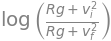

In [40]:
tau = sp.Symbol("tau")

m, g, R, vi, vf, ri, rf = sp.symbols(
    "m, g, R, v_i, v_f, r_i, r_f", real=True, positive=True
)

sp.integrate(-tau / (R * g + tau**2), (tau, vi, vf)) * 2

sp.logcombine(sp.integrate(-tau / (R * g + tau**2), (tau, vi, vf)) * 2)

### replacement

* [replace][] replace an expression. An example is found in [Young and Freedman][] solutions in sympy
* [xreplace][] replace occurrences of objects within the expression

[replace]: http://docs.sympy.org/latest/modules/core.html?highlight=match#sympy.core.basic.Basic.replace

[xreplace]:https://docs.sympy.org/latest/modules/core.html#sympy.core.basic.Basic.xreplace

[Young and Freedman]:../physics/books/YoungAndFreedman13/Chapter05-Applying-Newtons-Laws/Chapter05P110-Rotating-System.ipynb

# lambdify

In SymPy, the `lambdify` function is a utility that allows you to convert 
symbolic expressions into Python functions. It enables efficient numerical 
evaluation of SymPy expressions by generating a callable function that 
can be used to compute numerical values quickly.

The `lambdify` function takes two main arguments: the variables to be 
included in the generated function and the expression to be evaluated. 
It returns a Python function that can accept numerical inputs and 
evaluate the expression efficiently. The generated function uses 
NumPy for numerical computations, providing performance benefits.

Here's a summary of what `lambdify` does:

1. Converts SymPy expressions to efficient numerical functions: 
`lambdify` allows you to convert SymPy expressions into callable Python 
functions that can compute numerical values efficiently.

2. Supports various input types: The generated function can accept 
different types of inputs, including scalars, NumPy arrays, 
and mathematical constants.

3. Provides fast numerical evaluation: The generated function leverages 
the performance of NumPy to evaluate the expression using optimized 
numerical computations.

4. Supports variable substitution: You can specify the variables to 
include in the generated function, and the generated function will 
accept values for those variables as arguments.

5. Enables integration with numerical libraries: By converting SymPy 
expressions into numerical functions, you can seamlessly integrate them 
with other numerical libraries like NumPy, SciPy, and matplotlib for 
scientific computations and plotting.

Overall, `lambdify` bridges the gap between symbolic and numerical 
computation in SymPy by generating efficient numerical functions from 
symbolic expressions. It allows for fast and accurate evaluation of 
mathematical expressions, enabling seamless integration with numerical 
libraries and facilitating efficient numerical computations.

In [41]:
x, y = sp.symbols("x, y", real=True)
expr = sp.asin(x**2 / y) + PI
expr

In [42]:
expr_f = sp.lambdify([x, y], expr)
expr_f(1, 2)

In [43]:
# Define a symbolic expression
x = sp.symbols("x")
expr = sp.sin(x) + sp.cos(x)

# Create a lambda function from the symbolic expression using lambdify
f = sp.lambdify(x, expr, "numpy")

# Generate input values
x_vals = np.linspace(0, 2 * np.pi, 10)

# Evaluate the lambda function on the input values
result = f(x_vals)

# Print the result
print(result)

[ 1.          1.40883205  1.15845593  0.3660254  -0.59767248 -1.28171276
 -1.3660254  -0.81115958  0.12325683  1.        ]


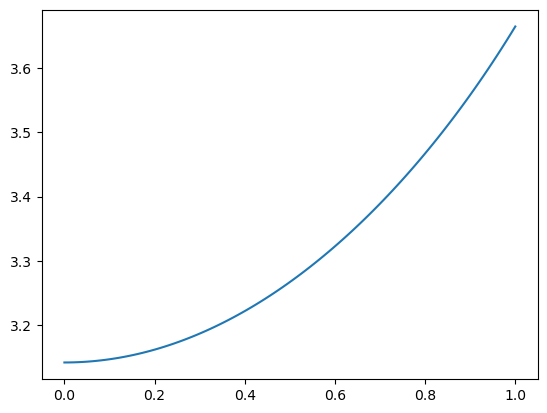

In [44]:
x_num = np.linspace(0, 1, 100)
y_num = 2
plt.plot(x_num, expr_f(x_num, y_num))

# Assumptions
Information about expressions

In [45]:
sp.ask(sp.Q.prime(7))

True

In [46]:
print(IPython.utils.text.columnize(dir(sp.Q)))

__class__              _hermitian          extended_nonnegative
__delattr__            _imaginary          extended_nonpositive
__dict__               _infinite           extended_nonzero    
__dir__                _integer            extended_positive   
__doc__                _integer_elements   extended_real       
__eq__                 _invertible         finite              
__format__             _irrational         fullrank            
__ge__                 _le                 ge                  
__getattribute__       _lower_triangular   gt                  
__gt__                 _lt                 hermitian           
__hash__               _ne                 imaginary           
__init__               _negative           infinite            
__init_subclass__      _negative_infinite  integer             
__le__                 _nonnegative        integer_elements    
__lt__                 _nonpositive        invertible          
__module__             _nonzero         

# Solve
1. [Solve Equations][]

[Solve Equations]:https://docs.sympy.org/latest/guides/solving/index.html#solve-equations

## Solve Algebraically

1. [Solve Algebraically][]

[Solve Algebraically]:https://docs.sympy.org/latest/guides/solving/solve-equation-algebraically.html#solve-an-equation-algebraically

In [47]:
x, y = sp.symbols("x, y", real=True)
(
    sp.solve(sp.Eq(x**2, y), x, dict=True),
    sp.solveset(sp.Eq(x**2, y), x, domain=sp.S.Reals),
)

In [48]:
eqn = sp.Eq(sp.sin(x), 0)
sp.solve(eqn, x)

## Solve set

In [49]:
# Define the variable
x = sp.Symbol("x")

domain = sp.Interval(0, 4 * PI)
eqn1 = sp.Eq(sp.sin(x), 0)
solution_set = sp.solveset(eqn1, x, domain=domain)

print_aligned_latex_equations(
    rf"\textrm{{for }} x \in {spv.vlatex(domain)}"
    rf"\; {spv.vlatex(eqn1)} "
    rf"\implies x \in {spv.vlatex(solution_set)} ",
)

domain = sp.Interval(0, 5 * PI)
eqn2 = sp.Eq(sp.sin(x), 1)
solution_set = sp.solveset(eqn2, x, domain=domain)

print_aligned_latex_equations(
    rf"\textrm{{for }} x \in {spv.vlatex(domain)}"
    rf"\; {spv.vlatex(eqn2)} "
    rf"\implies x \in {spv.vlatex(solution_set)} ",
)

domain = sp.S.Reals
eqn3 = sp.Eq(2**x, POSITIVEINFINITY)
solution_set = sp.solveset(eqn3, x, domain=domain)

print_aligned_latex_equations(
    rf"\textrm{{for }} x \in {spv.vlatex(domain)}"
    rf"\; {spv.vlatex(eqn3)} "
    rf"\implies x \in {spv.vlatex(solution_set)} ",
)

domain = sp.Interval(0, 4 * PI)
eqn4 = sp.Eq(sp.cos(x), 0)
solution_set = sp.solveset(eqn2, x, domain=domain)

print_aligned_latex_equations(
    rf"\textrm{{for }} x \in {spv.vlatex(domain)}"
    rf"\; {spv.vlatex(eqn4)} "
    rf"\implies x \in {spv.vlatex(solution_set)} ",
)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# dsolve

In [50]:
# This code calculates the velocity of a particle P at time t = 2 seconds,
# given that P moves with constant acceleration $(2i − 3j)ms^{-2}$ and
# at time $t = 0$, P is moving with velocity $4ims^{−1}$.


# Define the time variable.
t = sp.Symbol("t")

# Define the position, velocity, and acceleration of the particle.
rx, ry, rz = spv.dynamicsymbols("r_x, r_y, r_z")
r = sp.Matrix([rx, ry, rz])
v = r.diff()
a = v.diff()

# Define the initial conditions.
di = sp.Matrix([0, 0, 0])
vi = sp.Matrix([4, 0, 0])
ai = sp.Matrix([2, -3, 0])


# # Solve the differential equation for the distance.
acceleration_equation = [sp.Eq(a[_], ai[_]) for _ in range(3)]
acceleration_equation_solution = sp.dsolve(acceleration_equation)

# Solve the initial conditions for the constants in the distance solution.
distance_constants = sp.solve([
    sp.Eq(di[_], acceleration_equation_solution[_].rhs.subs(t, 0))
    for _ in range(3)
])

values = distance_constants

# Solve the equation for the velocity.
velocity = [acceleration_equation_solution[_].rhs.diff(t)
            for _ in range(3)
            ]

velocity_equation = [
    sp.Eq(velocity[_], vi[_]).subs(t, 0) for _ in range(3)
]

# Update constants derived from velocity equation.
values.update(sp.solve(velocity_equation))

dist = [_.subs(values) for _ in acceleration_equation_solution]
vel = [sp.Eq(_.lhs.diff(), _.rhs.diff().subs(values)) for _ in dist]
vel_t2 = [sp.Eq(_.lhs, _.rhs.subs(t, 2)) for _ in vel]
speed_t2 = sp.sqrt(sum(vel_t2[_].rhs**2 for _ in range(3)))

solution_text = [
    r'\textrm{acceleration equation} &:'
    fr'{spv.vlatex(acceleration_equation)}',
    r'\textrm{velocity } &:' fr'{spv.vlatex(vel)}',
    r'\textrm{distance equation} &:'
    fr'{spv.vlatex(dist)}',
    r'\textrm{velocity at t=2} &:'
    fr'{spv.vlatex(vel_t2)}',
    r'\textrm{Speed at t=2} &:'
    fr'{spv.vlatex(speed_t2)}',
]

print_aligned_latex_equations(*solution_text)

<IPython.core.display.Math object>

# Printing

## Pretty Printing

#TODO Cannot get dot notation for differentials to work. Do not understand
pretty printing at all


In [51]:
x = sp.Symbol("x")
sp.init_printing()
expr = sp.Integral(sp.sqrt((ONE / x), x))
sp.pprint(expr, use_unicode=True)


⌠           
⎮     ___   
⎮    ╱ 1    
⎮   ╱  ─  dx
⎮ ╲╱   x    
⌡           


In [52]:
x = sp.Symbol("x")
f = sp.Function("f")
spv.init_vprinting(pretty_print=True)
expr = f(x).diff()
sp.pprint(expr)


d       
──(f(x))
dx      


## Latex

In [53]:
R, m, g = sp.symbols("R, m, g", real=True, positive=True)
theta = spv.dynamicsymbols("theta", level=0)
theta_0, d_theta_0 = sp.symbols(r"\theta_{t=0}, \dot{\theta}_{t=0}")

F = reference_frame("F", x=r"E_1", y=r"E_2", z=r"E_3")
A = reference_frame("A", x=r"e_{\theta}", y=r"e_z", z=r"e_r")
A.orient_axis(F, F.y, theta)

vP = R * A.z
dvP, ddvP = vP.dt(F), vP.dt(F).dt(F)

N = sp.symbols("N", real=True, positive=True)

total_force = m * g * (-F.z) + N * A.z

N2Leqn = sp.Eq(total_force.to_matrix(F), m * ddvP.to_matrix(F)) 
print_aligned_latex_equations(
    rf"""
    \textrm{{Force on ball bearing }}\quad 
        &{spv.vlatex(total_force)} \\
    \textrm{{mass\(\cdot\) acceleration on ball bearing }}\quad 
        &{spv.vlatex(m*ddvP)} \\
    \textrm{{N2L applied to ball bearing }}\quad 
        &{spv.vlatex(N2Leqn)} \\
"""
)

<IPython.core.display.Math object>

## Latex text mode

Enter mathmode while in textmode  ```\( \)```

Notice centre dot $\cdot$ in this $$\textrm{{mass\(\cdot\) acceleration on ball bearing }}$$
a centre dot in text mode


# Function
* [Function][]
* [Expand][]
* [Subs][]
* [Assumptions][]
* [Elementary Functions, Piecewise](https://docs.sympy.org/latest/modules/functions/elementary.html)



[Function]: http://docs.sympy.org/latest/modules/core.html?highlight=match#sympy.core.function.Function

[Subs]: http://docs.sympy.org/latest/modules/core.html?highlight=match#sympy.core.function.Subs

[Expand]: http://docs.sympy.org/latest/modules/core.html?highlight=match#sympy.core.function.expand

[Assumptions]: http://docs.sympy.org/latest/modules/core.html#module-sympy.core.assumptions

In [54]:
assumptions = [
    "real",
    "extended_real",
    "complex",
    "imaginary",
    "integer",
    "irrational",
    "rational",
    "negative",
    "positive",
]

In [55]:
hints_expand = [
    "mul",
    "modulus",
    "power_base",
    "power_exp",
    "mul",
    "log",
    "multinomial",
    "basic",
    "complex",
    "func",
    "trig",
]

In [56]:
(
    sp.nsimplify(6.28, [sp.pi], tolerance=0.01),
    sp.nsimplify(0.33333, tolerance=0.001),
    sp.nsimplify(sp.cos(sp.atan(1.0 / 3))),
)

In [57]:
sp.simplify(sp.cos(x) ** 2 + sp.sin(x) ** 2)

In [58]:
funcs_expand = [
    sp.expand_log,
    sp.expand_mul,
    sp.expand_multinomial,
    sp.expand_complex,
    sp.expand_trig,
    sp.expand_power_base,
    sp.expand_power_exp,
    sp.expand_func,
    sp.hyperexpand,
]
funcs_expand

[<function sympy.core.function.expand_log(expr, deep=True, force=False, factor=False)>,
 <function sympy.core.function.expand_mul(expr, deep=True)>,
 <function sympy.core.function.expand_multinomial(expr, deep=True)>,
 <function sympy.core.function.expand_complex(expr, deep=True)>,
 <function sympy.core.function.expand_trig(expr, deep=True)>,
 <function sympy.core.function.expand_power_base(expr, deep=True, force=False)>,
 <function sympy.core.function.expand_power_exp(expr, deep=True)>,
 <function sympy.core.function.expand_func(expr, deep=True)>,
 <function sympy.simplify.hyperexpand.hyperexpand(f, allow_hyper=False, rewrite='default', place=None)>]

In [59]:
sp.diff(sp.tan(x), x)

## Limit

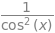

In [60]:
x = sp.symbols("x")
sp.limit((sp.tan(x + h) - sp.tan(x)) / h, h, 0)

In [61]:
sp.var("x, y, z")
f = 3 * x**2 * z + y * x * sp.cos(PI * x - PI * z)

In [62]:
f, sp.limit(f, x, 2).limit(y, 1).limit(z, -1)

In [63]:
f = x * y / (x + y)
f, f.limit(x, 5).limit(y, 1)

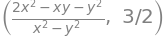

In [64]:
f = (2 * x**2 - x * y - y**2) / (x**2 - y**2)
f, f.limit(x, 1).limit(y, 1)

## Derivatives


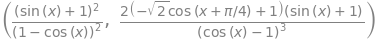

In [65]:
x = sp.symbols("x")
expr = ((1 + sp.sin(x)) / (1 - sp.cos(x))) ** 2
expr, expr.diff().simplify()

In [66]:
f, g = sp.symbols("f, g", cls=sp.Function)
f(x), g(x)

## Anti Derivatives

In [67]:
x = sp.symbols("x")
sp.integrate(sp.csc(x) * sp.cot(x))

In [68]:
sp.integrate(sp.exp(x) / sp.sqrt(sp.exp(2 * x) + 9), (x, 0, sp.log(4)))

In [69]:
t = sp.symbols("t")
sp.integrate(x**10 * sp.exp(x), (x, 1, t))

In [70]:
sp.integrate(sp.log(x), x)

In [71]:
sp.integrate(sp.exp(-(x**2)), (x, sp.S.NegativeInfinity, sp.S.Infinity))

In [72]:
sp.cos(x).series(x, 0, 10), sp.cos(x).series(x, 0, 10).removeO()

## Series

# Multivariable Calculus

## Partial Differentiation

In [73]:
(
    x,
    y,
    z,
) = sp.symbols("x:z")

In [74]:
f = 2 * x**3 * y**2 + y**3
fx = sp.diff(f, x)
fy = sp.diff(f, y)
fxx = sp.diff(f, x, x)
fyy = sp.diff(f, y, y)
fxy = sp.diff(f, x, y)
fyx = sp.diff(f, y, x)

print_aligned_latex_equations(
    rf"f(x,y) &= {spv.vlatex(f)}",
    rf"f_{{x}} &= {spv.vlatex(fx)}",
    rf"f_{{y}} &= {spv.vlatex(fy)}",
    rf"f_{{xx}} &= {spv.vlatex(fxx)}",
    rf"f_{{yy}} &= {spv.vlatex(fyy)}",
    rf"f_{{xy}} &= {spv.vlatex(fxy)}",
    rf"f_{{yx}} &= {spv.vlatex(fyx)}",
)

<IPython.core.display.Math object>

# Vectors and Geometry

### Differentiation

In [75]:
r = sp.Matrix([3 * t, sp.sin(t), t**2])
r.diff(t)

⎡  3   ⎤
⎢      ⎥
⎢cos(t)⎥
⎢      ⎥
⎣ 2⋅t  ⎦

### Integration

In [76]:
r = sp.Matrix([sp.exp(t) * sp.cos(t), t**4, 1 / (1 + t**2)])
r.integrate(t)

⎡ t           t       ⎤
⎢ℯ ⋅sin(t)   ℯ ⋅cos(t)⎥
⎢───────── + ─────────⎥
⎢    2           2    ⎥
⎢                     ⎥
⎢          5          ⎥
⎢         t           ⎥
⎢         ──          ⎥
⎢         5           ⎥
⎢                     ⎥
⎣       atan(t)       ⎦

# Pattern Matching
* [match][] in [Basic][]
* [Wild][]
* [WildFunction][]

[Basic]: http://docs.sympy.org/latest/modules/core.html?highlight=match#id15

[Wild]: http://docs.sympy.org/latest/modules/core.html?highlight=match#sympy.core.symbol.Wild

[WildFunction]: http://docs.sympy.org/latest/modules/core.html?highlight=match#sympy.core.function.WildFunction

[match]: http://docs.sympy.org/latest/modules/core.html?highlight=match#sympy.core.basic.Basic.match 

In [77]:
p = sp.Wild("p", exclude=[x])
q = sp.Wild("q", exclude=[x])
(5 * x**2 + 3 * x).match(p * x**2 + q * x), (x**2).match(p * x**q)

In [78]:
f = sp.WildFunction("f", nargs=1)
(5 * sp.cos(x)).match(p * f), (sp.cos(3 * x)).match(f)

# Calculus
* [Calculus][2]
* [Integrals][1]
* [Solving differential equations][3]
* [classify ODE][4]

[4]: http://docs.sympy.org/latest/modules/solvers/ode.html?highlight=dsolve#classify-ode
[3]: http://docs.sympy.org/latest/tutorial/solvers.html#solving-differential-equations
[2]: http://docs.sympy.org/latest/tutorial/calculus.html?highlight=dsolve#calculus
[1]: http://docs.sympy.org/latest/modules/integrals/integrals.html?highlight=sympy.integrals#module-sympy.integrals

# Series and Summations

Some examples of series and summations may be found in mathematical problems for physics.
  * [Summation][1]
  * [Series][2]

[1]: ../../Physics/Physics-Problems-To-Solve/physics-mechanics/physics-mechanics-SMR-P001-binomial-expansion-Summation.ipynb
[2]: ../../Physics/Physics-Problems-To-Solve/physics-mechanics/physics-mechanics-SMR-P001-binomial-expansion-Series.ipynb

# Matrices
1 [Matrices][]

[Matrices]: http://docs.sympy.org/latest/modules/matrices/matrices.html#module-sympy.matrices.matrices

## Selection

In [79]:
A = sp.Matrix(3, 3, sp.symbols("a:i", real=True))
A, A.shape, A.row(1)

⎛⎡a  b  c⎤                   ⎞
⎜⎢       ⎥                   ⎟
⎜⎢d  e  f⎥, (3, 3), [d  e  f]⎟
⎜⎢       ⎥                   ⎟
⎝⎣g  h  i⎦                   ⎠

In [80]:
A.row_del(1)
A

⎡a  b  c⎤
⎢       ⎥
⎣g  h  i⎦

In [81]:
A = sp.Matrix(3, 3, sp.symbols("a:i", real=True))

In [82]:
A[0, :], A[1, :]

([a  b  c], [d  e  f])

In [83]:
n = 3
a = sp.symbols(f"a_1:{n+1}(1:{n+1})", real=True)
b = sp.symbols(f"b_1:{n+1}(1:{n+1})", real=True)
A, B = sp.Matrix(n, n, a), sp.Matrix(n, n, b)
A, B

⎛⎡a₁₁  a₁₂  a₁₃⎤  ⎡b₁₁  b₁₂  b₁₃⎤⎞
⎜⎢             ⎥  ⎢             ⎥⎟
⎜⎢a₂₁  a₂₂  a₂₃⎥, ⎢b₂₁  b₂₂  b₂₃⎥⎟
⎜⎢             ⎥  ⎢             ⎥⎟
⎝⎣a₃₁  a₃₂  a₃₃⎦  ⎣b₃₁  b₃₂  b₃₃⎦⎠

In [84]:
sp.eye(3), sp.zeros(1, 3), sp.ones(2)

⎛⎡1  0  0⎤                   ⎞
⎜⎢       ⎥             ⎡1  1⎤⎟
⎜⎢0  1  0⎥, [0  0  0], ⎢    ⎥⎟
⎜⎢       ⎥             ⎣1  1⎦⎟
⎝⎣0  0  1⎦                   ⎠

In [85]:
M = sp.eye(3)
M.row_del(0)
M

⎡0  1  0⎤
⎢       ⎥
⎣0  0  1⎦

In [86]:
M1 = sp.eye(n, n)
M1[1, 0] = 2
M1, A, M1 * A

⎛⎡1  0  0⎤  ⎡a₁₁  a₁₂  a₁₃⎤  ⎡    a₁₁          a₁₂          a₁₃    ⎤⎞
⎜⎢       ⎥  ⎢             ⎥  ⎢                                     ⎥⎟
⎜⎢2  1  0⎥, ⎢a₂₁  a₂₂  a₂₃⎥, ⎢2⋅a₁₁ + a₂₁  2⋅a₁₂ + a₂₂  2⋅a₁₃ + a₂₃⎥⎟
⎜⎢       ⎥  ⎢             ⎥  ⎢                                     ⎥⎟
⎝⎣0  0  1⎦  ⎣a₃₁  a₃₂  a₃₃⎦  ⎣    a₃₁          a₃₂          a₃₃    ⎦⎠

In [87]:
M, N = sp.zeros(1, 4), sp.zeros(1, 5)
M.row_join(N), M

([0  0  0  0  0  0  0  0  0], [0  0  0  0])

In [88]:
M.cols

## Reshape

In [89]:
A = sp.Matrix(2, 2, [-1, 2, 4, -8])
A

⎡-1  2 ⎤
⎢      ⎥
⎣4   -8⎦

In [90]:
b = sp.symbols("b_0:4", real=True)
B = sp.Matrix(2, 2, b)
B

⎡b₀  b₁⎤
⎢      ⎥
⎣b₂  b₃⎦

## Diagonal

In [91]:
a = sp.symbols("a_0:2", real=True)
b = sp.symbols("b_0:2", real=True)
A, B = sp.diag(*a), sp.diag(*b)
A, B, A * B

⎛⎡a₀  0 ⎤  ⎡b₀  0 ⎤  ⎡a₀⋅b₀    0  ⎤⎞
⎜⎢      ⎥, ⎢      ⎥, ⎢            ⎥⎟
⎝⎣0   a₁⎦  ⎣0   b₁⎦  ⎣  0    a₁⋅b₁⎦⎠

## Transpose

In [92]:
rng = np.random.default_rng(12345)
A = sp.Matrix(rng.integers(low=0, high=10, size=(5, 4)))
A, A.T

⎛⎡6  2  7  3⎤                 ⎞
⎜⎢          ⎥  ⎡6  2  9  5  2⎤⎟
⎜⎢2  7  6  6⎥  ⎢             ⎥⎟
⎜⎢          ⎥  ⎢2  7  3  5  6⎥⎟
⎜⎢9  3  8  3⎥, ⎢             ⎥⎟
⎜⎢          ⎥  ⎢7  6  8  2  6⎥⎟
⎜⎢5  5  2  1⎥  ⎢             ⎥⎟
⎜⎢          ⎥  ⎣3  6  3  1  9⎦⎟
⎝⎣2  6  6  9⎦                 ⎠

## Random Matrix

In [93]:
rng = np.random.default_rng(12345)
A = sp.Matrix(rng.integers(low=0, high=10, size=(5, 4)))
A, A.T

⎛⎡6  2  7  3⎤                 ⎞
⎜⎢          ⎥  ⎡6  2  9  5  2⎤⎟
⎜⎢2  7  6  6⎥  ⎢             ⎥⎟
⎜⎢          ⎥  ⎢2  7  3  5  6⎥⎟
⎜⎢9  3  8  3⎥, ⎢             ⎥⎟
⎜⎢          ⎥  ⎢7  6  8  2  6⎥⎟
⎜⎢5  5  2  1⎥  ⎢             ⎥⎟
⎜⎢          ⎥  ⎣3  6  3  1  9⎦⎟
⎝⎣2  6  6  9⎦                 ⎠

## Reduced Row Echelon Form

In [94]:
A = sp.Matrix(3, 4, [1, 2, 3, 4, 4, 5, 6, 7, 6, 7, 8, 9])
A, A.rref()

⎛⎡1  2  3  4⎤  ⎛⎡1  0  -1  -2⎤        ⎞⎞
⎜⎢          ⎥  ⎜⎢            ⎥        ⎟⎟
⎜⎢4  5  6  7⎥, ⎜⎢0  1  2   3 ⎥, (0, 1)⎟⎟
⎜⎢          ⎥  ⎜⎢            ⎥        ⎟⎟
⎝⎣6  7  8  9⎦  ⎝⎣0  0  0   0 ⎦        ⎠⎠

## LU Decomposition

In [95]:
A = sp.Matrix(3, 3, [-3, 2, -1, 6, -6, 7, 3, -4, 4])
R = A.LUdecomposition()
A, R, R[0] * R[1]

⎛⎡-3  2   -1⎤  ⎛⎡1   0  0⎤  ⎡-3  2   -1⎤    ⎞  ⎡-3  2   -1⎤⎞
⎜⎢          ⎥  ⎜⎢        ⎥  ⎢          ⎥    ⎟  ⎢          ⎥⎟
⎜⎢6   -6  7 ⎥, ⎜⎢-2  1  0⎥, ⎢0   -2  5 ⎥, []⎟, ⎢6   -6  7 ⎥⎟
⎜⎢          ⎥  ⎜⎢        ⎥  ⎢          ⎥    ⎟  ⎢          ⎥⎟
⎝⎣3   -4  4 ⎦  ⎝⎣-1  1  1⎦  ⎣0   0   -2⎦    ⎠  ⎣3   -4  4 ⎦⎠

## Gram Schmidt

In [96]:
v1, v2 = sp.Matrix(3, 1, [1, 1, 1]), sp.Matrix(3, 1, [0, 1, 1])
v1, v2, sp.matrices.GramSchmidt([v1, v2], orthonormal=True)

⎛          ⎡⎡√3⎤  ⎡-√6 ⎤⎤⎞
⎜          ⎢⎢──⎥  ⎢────⎥⎥⎟
⎜          ⎢⎢3 ⎥  ⎢ 3  ⎥⎥⎟
⎜⎡1⎤  ⎡0⎤  ⎢⎢  ⎥  ⎢    ⎥⎥⎟
⎜⎢ ⎥  ⎢ ⎥  ⎢⎢√3⎥  ⎢ √6 ⎥⎥⎟
⎜⎢1⎥, ⎢1⎥, ⎢⎢──⎥, ⎢ ── ⎥⎥⎟
⎜⎢ ⎥  ⎢ ⎥  ⎢⎢3 ⎥  ⎢ 6  ⎥⎥⎟
⎜⎣1⎦  ⎣1⎦  ⎢⎢  ⎥  ⎢    ⎥⎥⎟
⎜          ⎢⎢√3⎥  ⎢ √6 ⎥⎥⎟
⎜          ⎢⎢──⎥  ⎢ ── ⎥⎥⎟
⎝          ⎣⎣3 ⎦  ⎣ 6  ⎦⎦⎠

# Plotting

In [97]:
print(IPython.utils.text.columnize(plt.style.available))

Solarize_Light2      grayscale                  seaborn-v0_8-paper    
_classic_test_patch  seaborn-v0_8               seaborn-v0_8-pastel   
_mpl-gallery         seaborn-v0_8-bright        seaborn-v0_8-poster   
_mpl-gallery-nogrid  seaborn-v0_8-colorblind    seaborn-v0_8-talk     
bmh                  seaborn-v0_8-dark          seaborn-v0_8-ticks    
classic              seaborn-v0_8-dark-palette  seaborn-v0_8-white    
dark_background      seaborn-v0_8-darkgrid      seaborn-v0_8-whitegrid
fast                 seaborn-v0_8-deep          tableau-colorblind10  
fivethirtyeight      seaborn-v0_8-muted       
ggplot               seaborn-v0_8-notebook    



In [98]:
plt.style.use("fivethirtyeight")
plt.style.use("seaborn-v0_8")

## Plot 2D

### Plot and Plot List

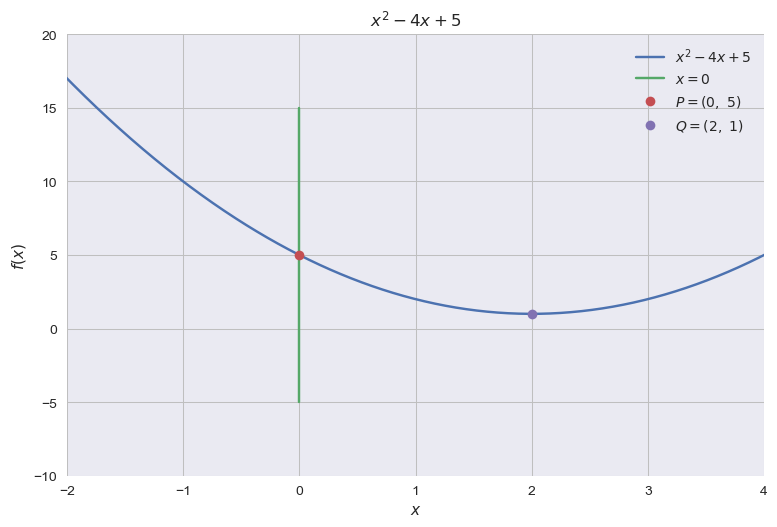

In [99]:
x = sp.symbols("x")
backend = spb.MB

f = x**2 - 4 * x + 5
P, Q = (0, 5), (2, 1)

p1 = spb.plot(
    f,
    (x, -5, +5),
    ylim=(-10, 20),
    xlim=(-2, 4),
    title=rf"${sp.latex(f)}$",
    show=False,
    backend=backend,
)

p2 = spb.plot_parametric(
    0, x, (x, -5, 15), "$x=0$", show=False, use_cm=False, backend=backend
)

p3 = spb.plot_list(
    ([P[0]], [P[1]], rf"$P={sp.latex(P)}$"),
    ([Q[0]], [Q[1]], rf"$Q={sp.latex(Q)}$"),
    show=False,
    use_cm=False,
    is_point=True,
    backend=backend,
)

(p1 + p2 + p3).show()

### Plot straight line y-axis

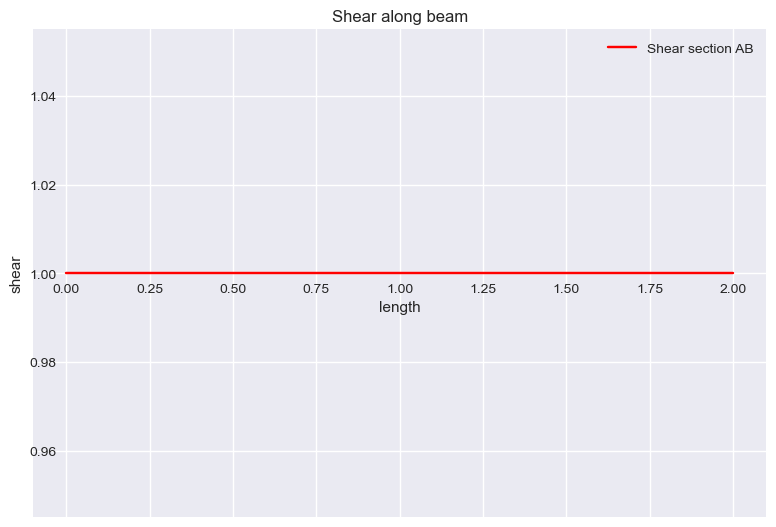

In [100]:
x = sp.symbols("x", real=True)
a = splt.plot(1, (x, 0, 2), show=False)
a.title = "Shear along beam"
a.legend = True
a[0].label = "Shear section AB"
a[0].line_color = "red"
a.xlabel = "length"
a.ylabel = "shear"
a.show()

In [101]:
W0, M0, w0, w1 = 10000, 10000, 4000, 4000
ell = [2, 2, 3, 3, 4]
exprACx = (1000 + 16000 * x - 2000 * x * x) / 3
exprACx

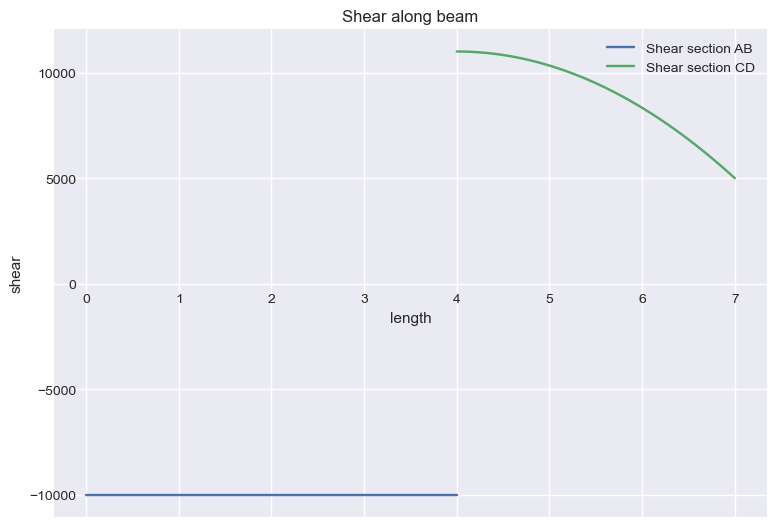

In [102]:
x = sp.symbols("x", real=True)
y = sp.symbols("y", real=True)

a = splt.plot(-W0, (x, 0, sum(ell[:2])), show=False)
b = splt.plot(exprACx, (x, sum(ell[:2]), sum(ell[:3])), show=False)
a.append(b[0])
# a.append(c[0])
a.title = "Shear along beam"
a.legend = True
a[0].label = "Shear section AB"
a[1].label = "Shear section CD"
a.xlabel = "length"
a.ylabel = "shear"
a.show()

### Plot straight line x-axis

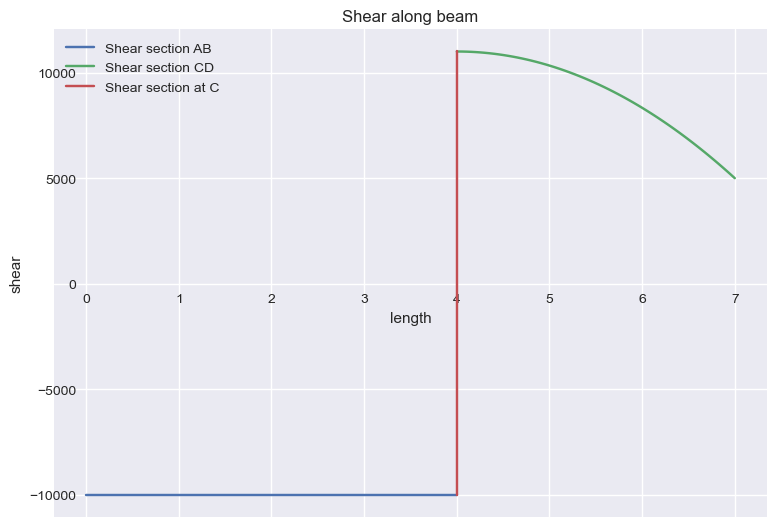

In [103]:
x = sp.symbols("x", real=True)
y = sp.symbols("y", real=True)

a = splt.plot(-W0, (x, 0, sum(ell[:2])), show=False)
b = splt.plot(exprACx, (x, sum(ell[:2]), sum(ell[:3])), show=False)
c = splt.plot_parametric((4, y), (y, -10000, 11000), show=False)
a.append(b[0])
a.append(c[0])
a.title = "Shear along beam"
a.legend = True
a[0].label = "Shear section AB"
a[1].label = "Shear section CD"
a[2].label = "Shear section at C"
a.xlabel = "length"
a.ylabel = "shear"
a.show()

### Plot piece-wise

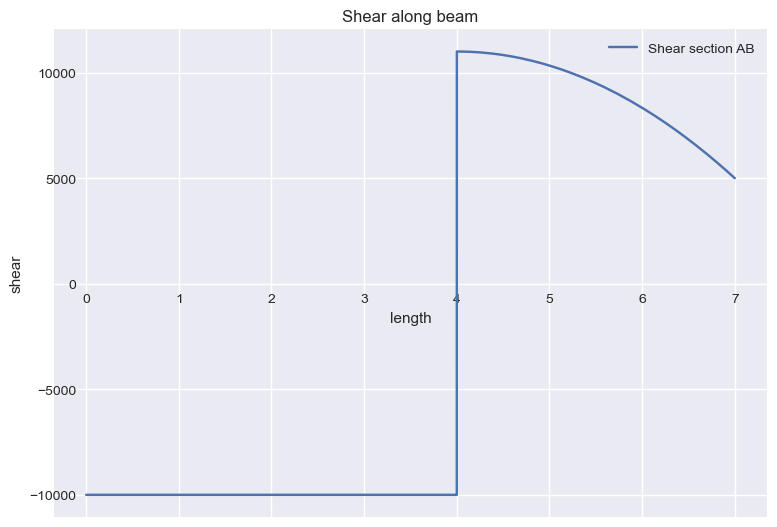

In [104]:
p = sp.Piecewise(
    (-W0, sp.Interval(0, 4).contains(x)),
    (exprACx, sp.Interval(4, 7).contains(x)),
)

x = sp.symbols("x", real=True)

a = splt.plot(p, (x, 0, sum(ell[:3])), show=False)
a.title = "Shear along beam"
a.legend = True
a[0].label = "Shear section AB"
a.xlabel = "length"
a.ylabel = "shear"
a.show()

### Scatter graph

In [105]:
# Define the data
x = [3, 6, 8, 7, 5, 3, 11, 3, 4, 5, 4, 9, 7, 10, 6, 6]
y = [7, 7, 4, 4, 6, 8, 5, 5, 8, 4, 7, 4, 5, 5, 6, 3]

backend = spb.BB

p1 = spb.plot_list(
    ((x, y, "x,y")),
    show=False,
    use_cm=False,
    is_point=True,
    backend=backend,
)

p1.show()

## Plot 3D

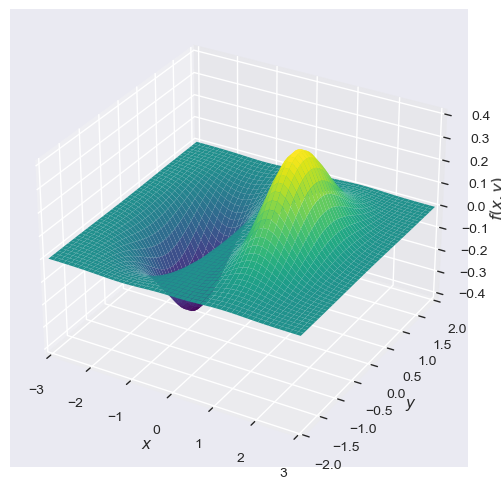

In [106]:
x = sp.symbols("x", real=True)
y = sp.symbols("y", real=True)

f = x**3 * sp.exp(-(x**2) - y**2)
a = splt.plot3d(f, (x, -3, +3), (y, -2, +2), size=(9, 5), show=False)
a.show()

# Numpy

## Integration

In [107]:
x = sp.symbols("x")
expr = (x**3 * sp.cos(x / 2) + HALF) * sp.sqrt(4 - x**2)
expr

In [108]:
expr_f = sp.lambdify([x], expr)

# Sympy stats

## Poisson Distribution, sampling and graphs

In [109]:
# Set backend to spm.MB
backend = spb.BB

# Create a Poisson distribution with mean 5 and name "Poisson_distribution"
poisson_distribution = ss.Poisson("Cars arriving", lamda=5)

# Generate a random sample of size 10000 from the Poisson distribution
random_sample = ss.sample(poisson_distribution, size=10000)

# Print the Frequency of occurrence
frequency = collections.Counter(random_sample)

# Sort the dictionary by keys
sorted_frequency = dict(sorted(frequency.items()))

# Plot the sorted frequency values as a line graph
p1 = spb.plot_list(
    list(sorted_frequency.keys()),
    list(sorted_frequency.values()),
    title="Frequency of occurrence",
    xlabel="Cars arriving",
    ylabel="Frequency",
    show=False,
    backend=backend,
)

# Plot the sorted frequency values as a scatter plot
p2 = spb.plot_list(
    list(sorted_frequency.keys()),
    list(sorted_frequency.values()),
    is_point=True,
    show=False,
    backend=backend,
)

# Display the combined plot
(p1 + p2).show()

## Binomial distribution, probabilities

In [110]:
# Constants
PROBABILITY_DANCER = 0.08
PROBABILITY_TANGOER = 0.12

# Define symbols
x = sp.symbols("x")

sample_size = 36
# Binomial distribution with sample size and probability
X = ss.Binomial("X", n=sample_size, p=PROBABILITY_DANCER)

# Calculate and round the probability P(X = 4)
PX_eq_4 = round(ss.P(sp.Eq(X, 4)).evalf(), 3)

# Calculate and round the probability P(X >= 7)
PX_ge_7 = round(ss.P(X >= 7).evalf(), 3)

# Store probabilities in a list for display
probabilities = [f"P(X = 4) & :{PX_eq_4}", f"P(X >= 7) & :{PX_ge_7}"]

# Print aligned LaTeX equations
print_aligned_latex_equations(*probabilities)

# Update sample size
sample_size = 50

# Define symbols
x = sp.symbols("x")

# Binomial distribution with updated sample size and probability
X = ss.Binomial("X", n=sample_size, p=PROBABILITY_TANGOER)

# Probability Mass Function (PMF) of X
pmf = ss.density(X)(x)

# Calculate and round the probability P(X < 3)
PX_lt_3_TANGOER = round(ss.P(sp.Lt(X, 3)).evalf(), 3)

# Store probability in a list for display
probabilities = [rf"\textrm{{Fewer than 3 Tangoers}} & :{PX_lt_3_TANGOER}"]

# Print aligned LaTeX equations
print_aligned_latex_equations(*probabilities)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [111]:
from IPython import utils
print(utils.text.columnize(dir(ipd)), sep='%')

Audio          Latex              __cached__          display_json          
Code           Markdown           __doc__             display_latex         
DisplayHandle  Math               __file__            display_markdown      
DisplayObject  Pretty             __loader__          display_pdf           
FileLink       ProgressBar        __name__            display_png           
FileLinks      SVG                __package__         display_pretty        
GeoJSON        ScribdDocument     __spec__            display_svg           
HTML           TextDisplayObject  clear_output        publish_display_data  
IFrame         Video              display             set_matplotlib_close  
Image          VimeoVideo         display_html        set_matplotlib_formats
JSON           YouTubeVideo       display_javascript  update_display        
Javascript     __builtins__       display_jpeg      



In [112]:
doctest.testmod(verbose=False)

TestResults(failed=0, attempted=49)